In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

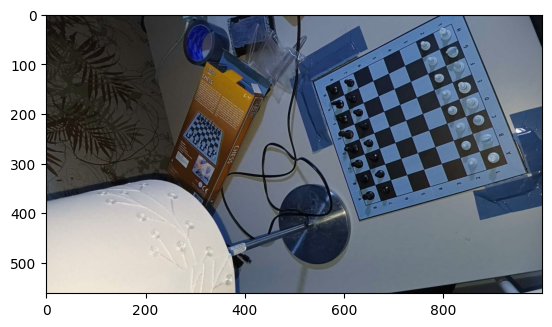

In [2]:
img_raw = cv2.imread("resources/nighttime_desk_capture.jpg")
plt.imshow(img_raw)